## Курсовой проект ##

#### Задача ####
На основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Целевая переменная ####
Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества ####
F1-score (sklearn.metrics.f1_score)

#### Требования к решению ####
F1( 𝛽 = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

In [1]:
# pip install catboost

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import catboost as catb

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (10, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [75]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [6]:
# пути к файлам

TRAIN_DATASET_PATH = './data/train.csv'
TEST_DATASET_PATH = './data/test.csv'

SUBMITION_PATH = './data/sample_submission.csv'

### Описание датасета ###

<ul>
<li><strong>Home Ownership</strong> - домовладение</li>
<li><strong>Annual Income</strong> - годовой доход</li>
<li><strong>Years in current job</strong> - количество лет на текущем месте работы</li>
<li><strong>Tax Liens</strong> - налоговые обременения</li>
<li><strong>Number of Open Accounts</strong> - количество открытых счетов</li>
<li><strong>Years of Credit History</strong> - количество лет кредитной истории</li>
<li><strong>Maximum Open Credit</strong> - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)</li>
<li><strong>Number of Credit Problems</strong> - количество проблем с кредитом</li>
<li><strong>Months since last delinquent</strong> - количество месяцев с последней просрочки платежа</li>
<li><strong>Bankruptcies</strong> - банкротства</li>
<li><strong>Purpose</strong> - цель кредита</li>
<li><strong>Term</strong> - срок кредита</li>
<li><strong>Current Loan Amount</strong> - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)</li>
<li><strong>Current Credit Balance</strong> - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)</li>
<li><strong>Monthly Debt</strong> - ежемесячный долг</li>
<li><strong>Credit Score</strong> - баллы кредитного рейтинга</li>
<li><strong>Credit Default</strong> - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)</li>
</ul>

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
train_df.shape, test_df.shape

((7500, 17), (2500, 16))

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Предварительный анализ данных

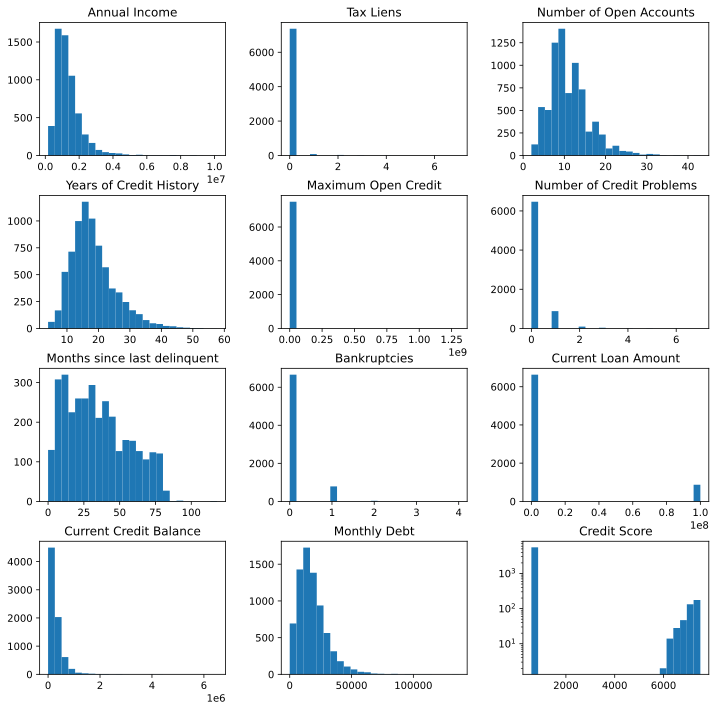

In [10]:
train_df.drop(['Credit Default'], axis=1, inplace=False).hist(figsize=(12,12), bins=25, grid=False)
plt.yscale('log')
plt.show()

### Обработка пропусков ###

In [11]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [12]:
test_df.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

#### Annual Income / Credit Score 

In [13]:
train_df.loc[train_df['Annual Income'].isna()].head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
10,Home Mortgage,NaN,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0
16,Rent,NaN,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1


In [14]:
(train_df[train_df['Annual Income'].isna()].index != train_df[train_df['Credit Score'].isna()].index).sum()

0

In [15]:
# Предполагаю, что кредитный рейтинг не может быть посчитан при отсутсвии данных о годовом доходе. 

train_df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

In [16]:
train_df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [17]:
train_df.loc[train_df['Annual Income'].isna(), 'Annual Income'] = -9999
train_df['Annual Income'].isna().sum()

0

In [18]:
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score'] = -9999
train_df['Credit Score'].isna().sum()

0

#### Years in current job

In [19]:
train_df['Years in current job'].describe()

count          7129
unique           11
top       10+ years
freq           2332
Name: Years in current job, dtype: object

In [20]:
train_df.loc[train_df['Years in current job'].isna()].sample(n = 10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
3628,Own Home,376314.0,NaN,0.0,8.0,51.3,139436.0,1.0,NaN,1.0,debt consolidation,Short Term,78980.0,99712.0,9972.0,720.0,0
667,Rent,-9999.0,NaN,0.0,15.0,16.0,413820.0,0.0,NaN,0.0,other,Short Term,222794.0,302366.0,18962.0,-9999.0,1
4741,Rent,1271347.0,NaN,0.0,16.0,20.0,425634.0,1.0,NaN,1.0,debt consolidation,Short Term,197736.0,264670.0,18858.0,717.0,0
4172,Own Home,471485.0,NaN,0.0,14.0,17.7,517352.0,1.0,NaN,1.0,debt consolidation,Short Term,152856.0,234574.0,6876.0,728.0,0
5079,Home Mortgage,2124067.0,NaN,0.0,8.0,15.0,272668.0,0.0,49.0,0.0,other,Long Term,670758.0,68989.0,34693.0,665.0,0
1159,Rent,-9999.0,NaN,0.0,6.0,15.5,123706.0,0.0,31.0,0.0,debt consolidation,Short Term,273592.0,52136.0,19647.0,-9999.0,1
6286,Home Mortgage,1535656.0,NaN,0.0,12.0,31.4,689590.0,0.0,NaN,0.0,home improvements,Short Term,111144.0,305520.0,20987.0,740.0,0
4145,Home Mortgage,1197874.0,NaN,0.0,9.0,17.3,619564.0,0.0,21.0,0.0,debt consolidation,Short Term,445984.0,250420.0,21062.0,733.0,0
2225,Rent,-9999.0,NaN,0.0,8.0,35.6,538846.0,0.0,NaN,0.0,debt consolidation,Short Term,330110.0,303430.0,12753.0,-9999.0,0
6326,Rent,226765.0,NaN,0.0,22.0,15.6,166386.0,0.0,79.0,0.0,buy a car,Short Term,65648.0,40242.0,4554.0,712.0,1


In [21]:
# Если Credit Score == NaN и Years in current job == NaN, можно предположить, что у заемщика нет опыта 
# работы либо нет данных

# Years in current job == NaN и есть кредитный рейтинг, то возможно заёмщик уже не работает

In [22]:
train_df.loc[(train_df['Years in current job'].isna()) & (train_df['Credit Score'] == -9999), \
             'Years in current job'] = "-1"

train_df.loc[(train_df['Years in current job'].isna()) & (train_df['Credit Score'] != -9999), \
             'Years in current job'] = "11"

In [23]:
train_df['Years in current job'].unique()

array(['11', '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '-1',
       '9 years'], dtype=object)

In [24]:
label_dict = {'10+ years': 10, '8 years': 8, '6 years': 6, '7 years': 7, '5 years': 5,
       '1 year': 1, '< 1 year': 0, '4 years': 4, '3 years': 3, '2 years': 2, '9 years': 9, '11': 11, '-1': -1}
train_df['Years in current job'] = train_df['Years in current job'].map(label_dict)

In [25]:
train_df['Years in current job'].isna().sum()

0

#### Months since last delinquent

<AxesSubplot:ylabel='Frequency'>

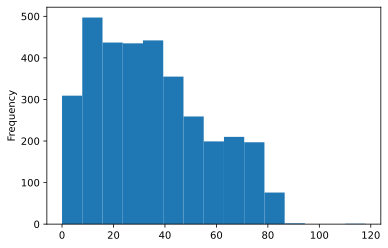

In [26]:
train_df['Months since last delinquent'].plot(kind='hist', bins=15)

In [27]:
train_df[train_df['Months since last delinquent'].isna()].sample(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1301,Own Home,1074013.0,5,0.0,11.0,10.7,316316.0,0.0,NaN,0.0,debt consolidation,Long Term,334158.0,261155.0,9004.0,674.0,0
883,Rent,813637.0,0,0.0,9.0,9.9,473902.0,0.0,NaN,0.0,other,Short Term,99999999.0,83486.0,9282.0,738.0,0
1521,Home Mortgage,1818053.0,10,0.0,25.0,29.0,1204346.0,0.0,NaN,0.0,debt consolidation,Long Term,590722.0,571026.0,18787.0,702.0,1
798,Own Home,-9999.0,10,0.0,12.0,16.1,1241350.0,0.0,NaN,0.0,debt consolidation,Long Term,259886.0,707560.0,31963.0,-9999.0,0
6290,Rent,1632442.0,3,0.0,5.0,11.6,393426.0,0.0,NaN,0.0,debt consolidation,Short Term,400268.0,272498.0,5142.0,712.0,0


In [28]:
train_df.loc[train_df['Months since last delinquent'].isna(), 'Months since last delinquent'] = -1

#### Bankruptcies

In [29]:
train_df['Bankruptcies'].isna().sum()

14

In [30]:
train_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies'] = -1

In [31]:
train_df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### Анализ количественных данных

In [32]:
# уберем категориальные в одтельную переменную
cat_features = train_df.select_dtypes('object').columns.to_list()

# целевая переменная
target_name = 'Credit Default'

In [33]:
numeric_features = train_df.select_dtypes('float64').columns.to_list()
numeric_features

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [34]:
train_df[numeric_features].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000
mean,1.080653e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,15.271067,0.115067,1.187318e+07,2.898332e+05,18314.454133,-1163.670667
std,9.369691e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,23.031689,0.350204,3.192612e+07,3.178714e+05,11926.764673,4742.800203
min,-9.999000e+03,0.000000,2.000000,4.000000,0.000000e+00,0.000000,-1.000000,-1.000000,1.124200e+04,0.000000e+00,0.000000,-9999.000000
25%,5.327268e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,-1.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,667.000000
50%,9.891305e+05,0.000000,10.000000,17.000000,4.781590e+05,0.000000,-1.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,722.000000
75%,1.499974e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,29.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000


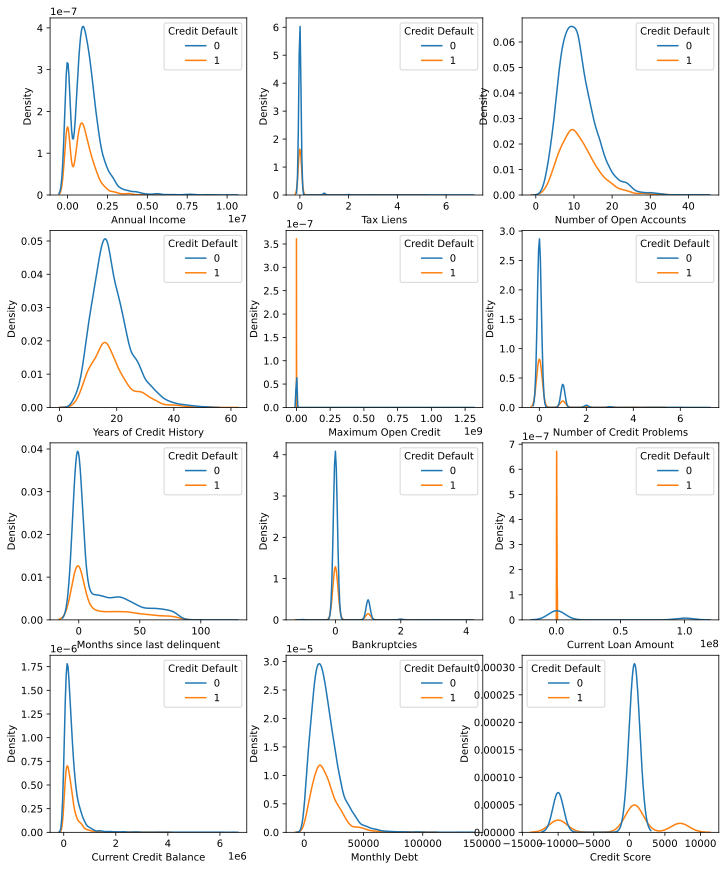

In [35]:
i, j = 0, 0

fig, ax = plt.subplots(4, 3, figsize=(12,15))

for feat in numeric_features:
    sns.kdeplot(data=train_df, hue=target_name, x=feat, ax=ax[j, i])
    
    if i < 2:
        i += 1    
    else:      
        i = 0
        j += 1
        
fig.show()

### Анализ и обработка категориальных признаков

In [36]:
for col in cat_features:
    print(str(col) + '\n\n' + str(train_df[col].value_counts()) + '\n' + '*' * 50 + '\n')
    train_df[col] = train_df[col].astype('str')
    

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
**************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
**************************************************

Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
**************************************************



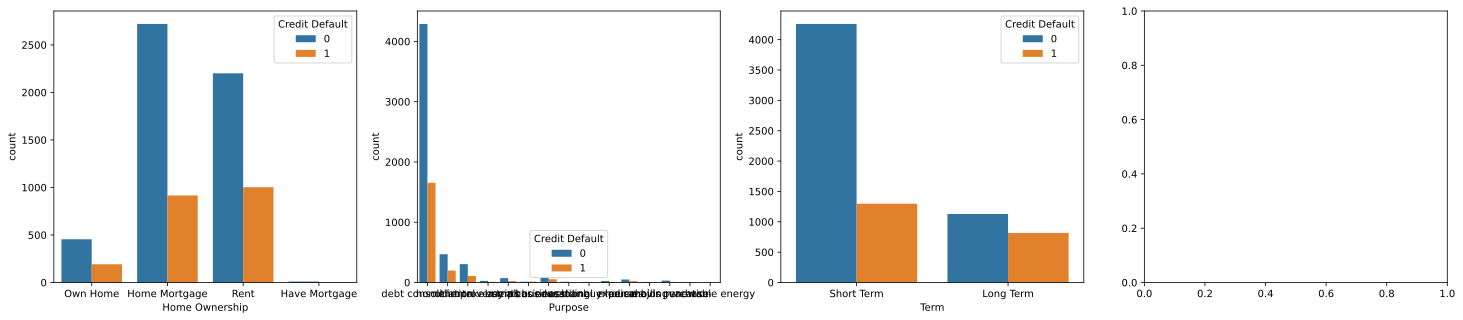

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

for i, feat in enumerate(cat_features):
    
    sns.countplot(x=feat, hue=target_name, data=train_df, ax=ax[i])
        
fig.show()


In [38]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Home Ownership'], prefix='Ownership')], axis=1)
train_df.drop(['Home Ownership'], axis=1, inplace=True)

In [39]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Purpose'], prefix='Purpose')], axis=1)
train_df.drop(['Purpose'], axis=1, inplace=True)

In [40]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Term'], prefix='Term')], axis=1)
train_df.drop(['Term'], axis=1, inplace=True)

### BASELINE

In [41]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        pass
        

    def fit(self, X):
        pass


    
    def transform(self, X):
        """Трансформация данных"""

        # Обработка пропусков
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = -9999
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = -9999
        X.loc[(X['Years in current job'].isna()) & (X['Credit Score'] == -9999), \
             'Years in current job'] = "-1"
        X.loc[(X['Years in current job'].isna()) & (X['Credit Score'] != -9999), \
             'Years in current job'] = "11"

        label_dict = {'10+ years': 10, '8 years': 8, '6 years': 6, '7 years': 7, '5 years': 5,
                        '1 year': 1, '< 1 year': 0, '4 years': 4, '3 years': 3, '2 years': 2, '9 years': 9, '11': 11, '-1': -1}
        X['Years in current job'] = X['Years in current job'].map(label_dict)
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = -1
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = -1
        
        # Обработка категориальных
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'], prefix='Ownership')], axis=1)
        X.drop(['Home Ownership'], axis=1, inplace=True)

        X = pd.concat([X, pd.get_dummies(X['Purpose'], prefix='Purpose')], axis=1)
        X.drop(['Purpose'], axis=1, inplace=True)

        X = pd.concat([X, pd.get_dummies(X['Term'], prefix='Term')], axis=1)
        X.drop(['Term'], axis=1, inplace=True)

        return X

In [42]:
FEATURES = train_df.drop(target_name, axis=1).columns.to_list()
FEATURES

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Ownership_Have Mortgage',
 'Ownership_Home Mortgage',
 'Ownership_Own Home',
 'Ownership_Rent',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',
 'Term_Long Term',
 'Term_Short Term']

In [43]:
FEATURES = [
'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
#  'Ownership_Have Mortgage',
 'Ownership_Home Mortgage',
 'Ownership_Own Home',
 'Ownership_Rent',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
#  'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
#  'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',
#  'Term_Long Term',
 'Term_Short Term'
]

In [80]:
# перезагружаем датафреймы

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [81]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [82]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5025, 33), (2475, 34), (2500, 33))

In [83]:
X_train = X_train[FEATURES]
X_valid = X_valid[FEATURES]
test_df = test_df[FEATURES]

In [84]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [85]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    3631
1    2788
Name: Credit Default, dtype: int64

In [86]:
X_train = df_balanced.drop(columns=target_name)
y_train = df_balanced[target_name]

X_train.shape, y_train.shape

((6419, 30), (6419,))

In [87]:
scale = y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0]
scale

1.302367288378766

In [88]:
cb_model = catb.CatBoostClassifier(n_estimators=100, max_depth=4, scale_pos_weight=scale, \
                                  silent=True, random_state=42)

cb_model.fit(X_train, y_train)

y_train_pred = cb_model.predict(X_train)
y_valid_pred = cb_model.predict(X_valid)
y_valid_pred_probs = cb_model.predict_proba(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      3631
           1       0.75      0.80      0.77      2788

    accuracy                           0.79      6419
   macro avg       0.79      0.80      0.79      6419
weighted avg       0.80      0.79      0.80      6419

TEST

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1756
           1       0.48      0.60      0.53       719

    accuracy                           0.69      2475
   macro avg       0.65      0.67      0.65      2475
weighted avg       0.72      0.69      0.70      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1286  470
1                287  432


### Обучение с новыми признаками

In [51]:
# Чистый долг
train_df['Clear debt'] = train_df['Current Loan Amount'] - train_df['Annual Income']
train_df['Clear debt'].describe()

count    5.943000e+03
mean     1.353863e+07
std      3.522600e+07
min     -9.484526e+06
25%     -1.178695e+06
50%     -7.509180e+05
75%     -4.436640e+05
max      9.978328e+07
Name: Clear debt, dtype: float64

In [52]:
# Период выплаты кредита из дохода
train_df['Pay period'] = train_df['Current Loan Amount'] / train_df['Annual Income']
train_df['Pay period'].describe()

count    5943.000000
mean       13.863034
std        38.594180
min         0.009653
25%         0.170638
50%         0.270172
75%         0.416251
max       461.437651
Name: Pay period, dtype: float64

In [53]:
# Доля платежа по кредиту в доходе
train_df['Pay fraction'] = train_df['Monthly Debt'] * 12 / train_df['Annual Income']
train_df['Pay fraction'].describe()

count    5943.000000
mean        0.171363
std         0.079256
min         0.000000
25%         0.112000
50%         0.167005
75%         0.227003
max         0.399009
Name: Pay fraction, dtype: float64

In [54]:
class FeatureGenetator():
    """Генерация новых фич"""

    def __init__(self):
        pass


    def fit(self, X, y=None):

        pass


    def transform(self, X):
        
        # Чистый долг
        X['Clear debt'] = X['Current Loan Amount'] - X['Annual Income']

        # Период выплаты кредита из дохода
        X['Pay period'] = X['Current Loan Amount'] / X['Annual Income']

        # Доля платежа по кредиту в доходе
        X['Pay fraction'] = X['Monthly Debt'] * 12 / X['Annual Income']

        return X


In [55]:
NEW_FEATURES = [
    'Clear debt',
    'Pay period',
    'Pay fraction'
]

In [111]:
# перезагружаем датафреймы

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [112]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=42)

In [113]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5250, 33), (2250, 34), (2500, 33))

In [114]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5250, 36), (2250, 37), (2500, 36))

In [115]:
X_train = X_train[FEATURES + NEW_FEATURES]
X_valid = X_valid[FEATURES + NEW_FEATURES]
test_df = test_df[FEATURES + NEW_FEATURES]

In [116]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [117]:
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
# df_balanced[target_name].value_counts()

In [118]:
# X_train = df_balanced.drop(columns=target_name)
# y_train = df_balanced[target_name]

# X_train.shape, y_train.shape

In [119]:
scale = y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0]
scale

2.6082474226804124

In [120]:
# стандартизация
scaler = StandardScaler()


X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_valid[numeric_features] = scaler.transform(X_valid[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

In [121]:
cb_model = catb.CatBoostClassifier(n_estimators=100, 
                                   max_depth=4,
                                   scale_pos_weight=scale,
                                   silent=True,
                                   random_state=42,
                                   custom_metric=['Precision', 'Recall']
                                  )

cb_model.fit(X_train, y_train)

y_train_pred = cb_model.predict(X_train)
y_valid_pred = cb_model.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.79      0.84      3795
           1       0.59      0.78      0.67      1455

    accuracy                           0.79      5250
   macro avg       0.74      0.78      0.76      5250
weighted avg       0.82      0.79      0.79      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1592
           1       0.49      0.64      0.56       658

    accuracy                           0.70      2250
   macro avg       0.66      0.68      0.67      2250
weighted avg       0.73      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1165  427
1                240  418


In [65]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

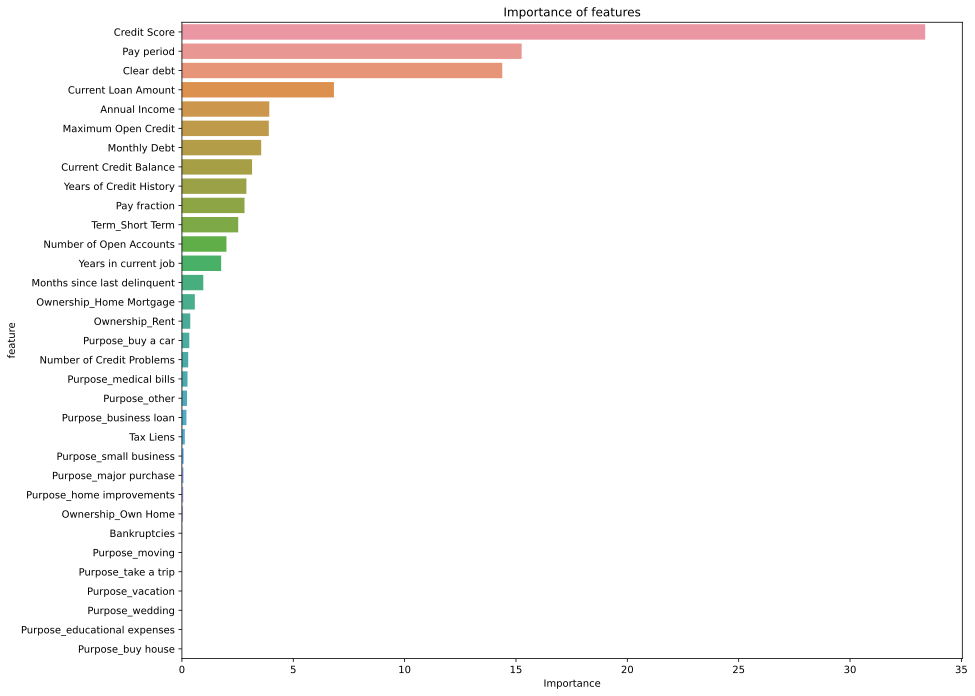

In [100]:
from catboost import Pool

train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_valid, label=y_valid)

# fi = cb_model.get_feature_importance(train_pool, type='LossFunctionChange') 
fi = cb_model.get_feature_importance(test_pool, type='PredictionValuesChange')
show_feature_importances(X_train.columns, fi)

### Выбор порога вероятности определения класса

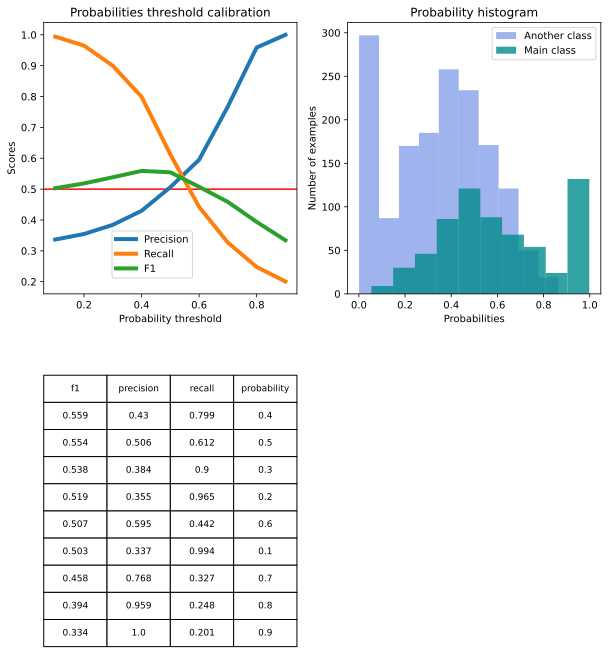

In [126]:
y_valid_pred_probs = cb_model.predict_proba(X_valid)[:, 1]
show_proba_calibration_plots(y_valid_pred_probs, y_valid)

### Подбор лучших параметров модели

In [123]:
cb_model = catb.CatBoostClassifier(  custom_loss=['F1'],
                                     silent=True, 
                                     random_state=42)
grid = {
    'learning_rate': [0.05, 0.1],
    'depth':[4, 6, 8],
    'n_estimators':[500, 800, 1200]
}
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_valid, label=y_valid)

grid_search_results = cb_model.grid_search(grid, train_pool, cv=3, stratified=True,
                                             verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.4774509131
bestIteration = 157


bestTest = 0.4791732987
bestIteration = 73


bestTest = 0.4774509131
bestIteration = 157


bestTest = 0.4791732987
bestIteration = 73


bestTest = 0.4774509131
bestIteration = 157


bestTest = 0.4791732987
bestIteration = 73


bestTest = 0.4784573696
bestIteration = 94


bestTest = 0.4803900949
bestIteration = 59


bestTest = 0.4784573696
bestIteration = 94


bestTest = 0.4803900949
bestIteration = 59


bestTest = 0.4784573696
bestIteration = 94


bestTest = 0.4803900949
bestIteration = 59


bestTest = 0.4830081172
bestIteration = 76


bestTest = 0.4845111993
bestIteration = 51


bestTest = 0.4830081172
bestIteration = 76


bestTest = 0.4845111993
bestIteration = 51


bestTest = 0.4830081172
bestIteration = 76


bestTest = 0.4845111993
bestIteration = 51



In [124]:
grid_search_results['params']

{'depth': 4, 'iterations': 500, 'learning_rate': 0.05}

### Настройка финальной модели

In [145]:
cb_model = catb.CatBoostClassifier(n_estimators=500, max_depth=4, 
                                   scale_pos_weight=scale, 
                                  silent=True, random_state=42, eval_metric='F1', learning_rate=0.05)

cb_model.fit(X_train, y_train)

y_train_pred = cb_model.predict(X_train)
y_valid_pred = cb_model.predict(X_valid)
# y_valid_pred_probs = cb_model.predict_proba(X_valid)

y_valid_pred_probs = cb_model.predict_proba(X_valid)[:, 1]
y_valid_pred = np.array(y_test_pred_probs > 0.55, dtype=int)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.83      0.87      3795
           1       0.65      0.83      0.73      1455

    accuracy                           0.83      5250
   macro avg       0.79      0.83      0.80      5250
weighted avg       0.85      0.83      0.83      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1592
           1       0.53      0.52      0.53       658

    accuracy                           0.73      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.72      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1294  298
1                316  342


In [164]:
prediction = cb_model.predict_proba(test_df)[:, 1]
prediction

array([0.61740305, 0.64486044, 0.99600428, ..., 0.58578418, 0.44396376,
       0.99436964])

In [165]:
submit_predicton = np.where(
    prediction > 0.55, 1, 0
)
submit_predicton

array([1, 1, 1, ..., 1, 0, 1])

In [148]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.head(5)

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [166]:
submit['Credit Default'] = submit_predicton
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0


In [167]:
submit.to_csv('rf_submit.csv', index=False)